In [14]:
from pathlib import Path
import pandas as pd

raw_dir = Path.cwd().parent / "raw_data"
csv_files = sorted(raw_dir.glob("*.csv"))

SEPS = [";", ",", "\t", "|"]
ENCODINGS = ["utf-8-sig", "utf-8", "cp1252"]

def detect_sep_and_start(f: Path, n_lines=60):
    # Läs några rader som text (testa vanliga encodings)
    txt = None
    for enc in ENCODINGS:
        try:
            txt = f.read_text(encoding=enc, errors="strict").splitlines()
            used_enc = enc
            break
        except UnicodeDecodeError:
            continue
    if txt is None:
        # fallback
        txt = f.read_text(encoding="utf-8", errors="replace").splitlines()
        used_enc = "utf-8(replace)"

    lines = txt[:n_lines]

    # Välj separator som ger flest fält i "tabell-delen"
    best_sep, best_max = None, -1
    counts_per_sep = {}
    for sep in SEPS:
        counts = [ln.count(sep) for ln in lines]
        mx = max(counts) if counts else 0
        counts_per_sep[sep] = counts
        if mx > best_max:
            best_max = mx
            best_sep = sep

    # Start-rad = första raden som ser ut som tabell (max antal separators)
    counts = counts_per_sep[best_sep]
    start = next((i for i, c in enumerate(counts) if c == best_max), 0)
    return best_sep, start, used_enc

def read_skolverket_csv(f: Path):
    sep, start, enc = detect_sep_and_start(f)
    return pd.read_csv(
        f,
        sep=sep,
        encoding=enc if "replace" not in enc else "utf-8",
        engine="python",
        skiprows=start,
    )

dfs = {}
failed = []

for f in csv_files:
    try:
        dfs[f.stem] = read_skolverket_csv(f)
    except Exception as e:
        failed.append((f.name, type(e).__name__, str(e)))

print("OK:", len(dfs), "FAILED:", len(failed))
print("Exempel OK-fil:", next(iter(dfs)), dfs[next(iter(dfs))].shape if dfs else None)
print("Första fail:", failed[0] if failed else None)


OK: 29 FAILED: 0
Exempel OK-fil: behorighet_grundskola_2024_25 (2166, 12)
Första fail: None


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

raw_dir = Path.cwd().parent / "raw_data"

csv_path  = raw_dir / "Grundskola - Jämförelse av ämnesbetyg över tid 2025 Kommun_Åk9.csv"
xlsx_path = raw_dir / "Grundskola - Jämförelse av betygsresultat över tid 2025 Kommun_Åk9.xlsx"

# 1) CSV: اگر همان لودر robust قبلی را داری، از آن استفاده کن؛ وگرنه مستقیم بخوان
df_csv = pd.read_csv(csv_path, sep=None, engine="python", encoding="utf-8-sig")
print("CSV shape:", df_csv.shape)
print("CSV cols:", df_csv.columns.tolist())

# 2) XLSX: شیت‌ها را ببین
xls = pd.ExcelFile(xlsx_path)
print("XLSX sheets:", xls.sheet_names)

# یک شیت را بخوان (اولی)
df_xlsx = pd.read_excel(xlsx_path, sheet_name=xls.sheet_names[0])
print("XLSX shape:", df_xlsx.shape)
print("XLSX cols:", df_xlsx.columns.tolist())

# ---------- تابع کمکی برای ساخت نمودار خطی (بدون حدس سخت) ----------
def pick_col(df, hints):
    for c in df.columns:
        s = str(c).lower()
        if any(h in s for h in hints):
            return c
    return None

def plot_over_time(df, title):
    year_col = pick_col(df, ["år", "ar", "year"])
    subj_col = pick_col(df, ["ämne", "amne", "subject"])
    # یک ستون عددی به عنوان مقدار
    num_cols = df.select_dtypes(include="number").columns.tolist()
    val_col = num_cols[0] if num_cols else None

    print("\nDetected:", {"year": year_col, "subject": subj_col, "value": val_col})

    if year_col is None or val_col is None:
        print("این فایل برای رسم خودکار آماده نیست. ستون‌های بالا را ببین و دستی انتخاب کن.")
        return

    # اگر subject نبود، فقط روند کلی را رسم می‌کنیم
    if subj_col is None:
        d = df[[year_col, val_col]].dropna()
        d = d.groupby(year_col, as_index=False)[val_col].mean()
        ax = d.plot(x=year_col, y=val_col, kind="line", marker="o")
        ax.set_title(title)
        plt.tight_layout()
        plt.show()
        return

    d = df[[year_col, subj_col, val_col]].dropna()
    d = d.groupby([year_col, subj_col], as_index=False)[val_col].mean()
    piv = d.pivot(index=year_col, columns=subj_col, values=val_col).sort_index()

    ax = piv.plot(kind="line", marker="o")
    ax.set_title(title)
    ax.set_xlabel(year_col)
    ax.set_ylabel(val_col)
    plt.tight_layout()
    plt.show()

# 3) رسم نمونه
plot_over_time(df_csv,  "Ämnesbetyg över tid – Kommun Åk9 (CSV)")
plot_over_time(df_xlsx, "Betygsresultat över tid – Kommun Åk9 (XLSX)")


ParserError: Expected 2 fields in line 16, saw 11

In [21]:
from pathlib import Path
import pandas as pd

raw_dir = Path.cwd().parent / "raw_data"
csv_path = raw_dir / "Grundskola - Jämförelse av ämnesbetyg över tid 2025 Kommun_Åk9.csv"

SEPS = [";", ",", "\t", "|"]
ENCODINGS = ["utf-8-sig", "utf-8", "cp1252"]

def detect_sep_and_start(f: Path, n_lines=80):
    txt = None
    used_enc = None
    for enc in ENCODINGS:
        try:
            txt = f.read_text(encoding=enc, errors="strict").splitlines()
            used_enc = enc
            break
        except UnicodeDecodeError:
            continue
    if txt is None:
        txt = f.read_text(encoding="utf-8", errors="replace").splitlines()
        used_enc = "utf-8"

    lines = txt[:n_lines]

    best_sep, best_max = None, -1
    counts_per_sep = {}
    for sep in SEPS:
        counts = [ln.count(sep) for ln in lines]
        counts_per_sep[sep] = counts
        mx = max(counts) if counts else 0
        if mx > best_max:
            best_max = mx
            best_sep = sep

    counts = counts_per_sep[best_sep]
    start = next((i for i, c in enumerate(counts) if c == best_max), 0)
    return best_sep, start, used_enc

def read_skolverket_csv(f: Path):
    sep, start, enc = detect_sep_and_start(f)
    df = pd.read_csv(f, sep=sep, encoding=enc, engine="python", skiprows=start)
    return df, {"sep": sep, "skiprows": start, "encoding": enc}

df_csv, meta = read_skolverket_csv(csv_path)
print(meta)
print(df_csv.shape)
print(df_csv.columns.tolist())
df_csv.head()

xlsx_path = raw_dir / "Grundskola - Jämförelse av betygsresultat över tid 2025 Kommun_Åk9.xlsx"
xls = pd.ExcelFile(xlsx_path)
print(xls.sheet_names)
df_xlsx = pd.read_excel(xlsx_path, sheet_name=xls.sheet_names[0])
print(df_xlsx.shape)
print(df_xlsx.columns.tolist())
df_xlsx.head()



{'sep': ';', 'skiprows': 5, 'encoding': 'utf-8-sig'}
(14120, 17)
['Kommun', 'Kommunkod', 'Län', 'Länskod', 'Typ av huvudman', 'Andel (%) elever som fått godkänt betyg i respektive ämne', '2024/25', '2023/24', '2022/23', '2021/22', '2020/21', '2019/20', '2018/19', '2017/18', '2016/17', '2015/16', 'Unnamed: 16']
['Samtliga', 'Kommunal', 'Enskild', 'Rapportbeskrivning och def.']
(2617, 15)
['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Grundskola - Jämförelse av betygsresultat över...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Typ av huvudman: Samtliga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Valt läsår: 2024/25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


READ META: {'sep': ';', 'skiprows': 5, 'encoding': 'utf-8-sig'}
SHAPE: (14120, 17)
YEAR COLS: ['2024/25', '2023/24', '2022/23', '2021/22', '2020/21', '2019/20', '2018/19', '2017/18', '2016/17', '2015/16']
LATEST YEAR: 2024/25


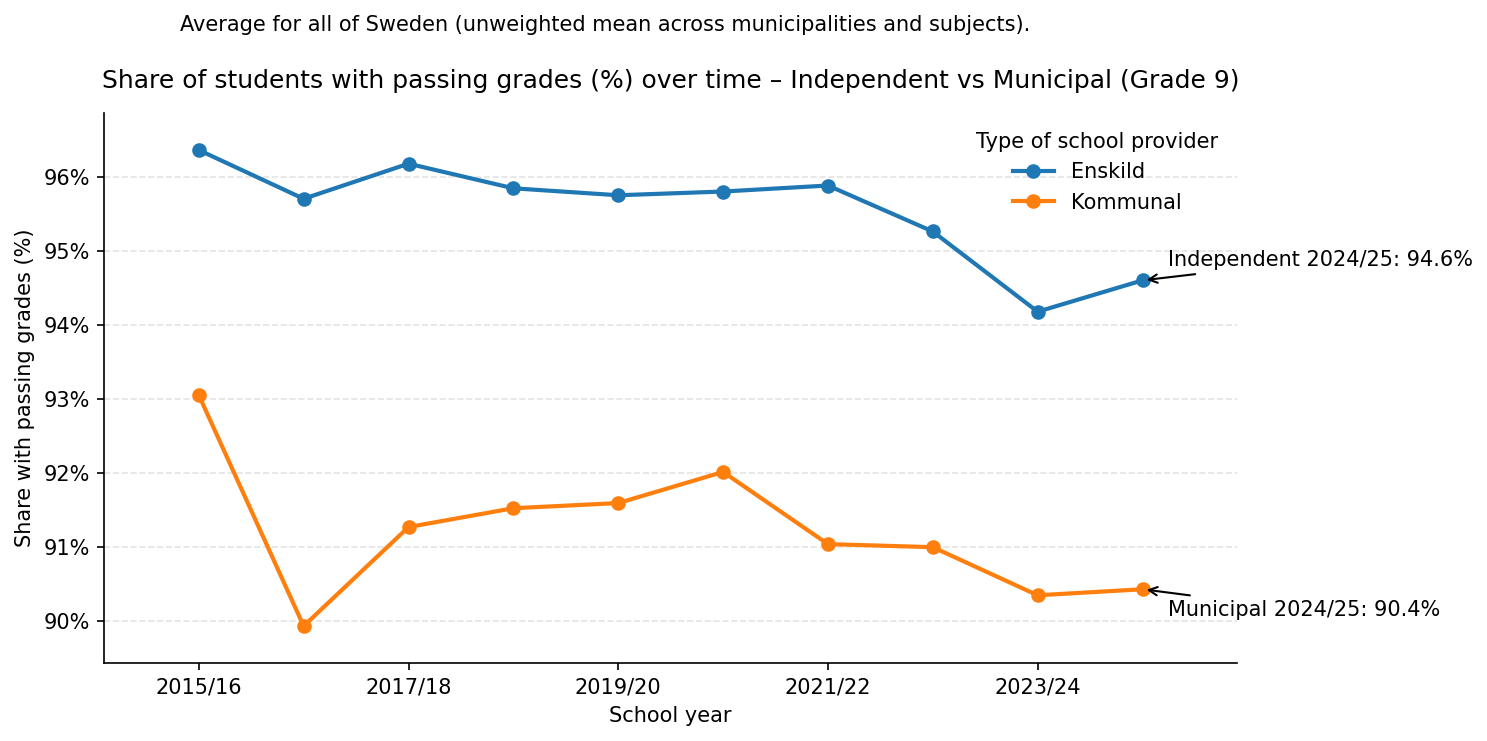

ROWS IN LATEST YEAR: 7701


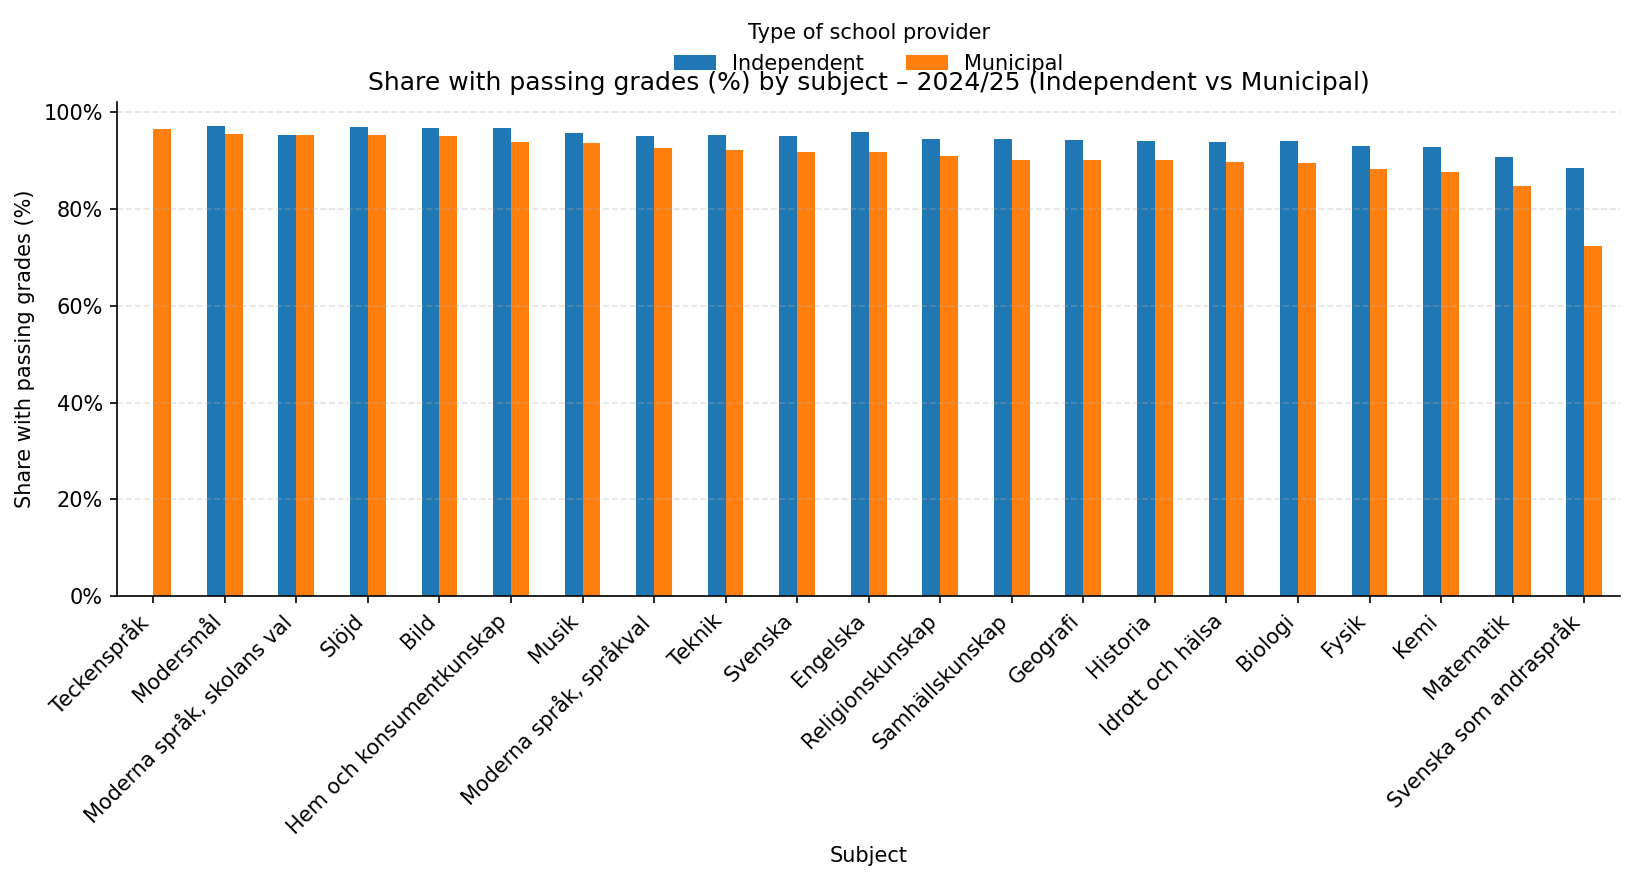

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# --- PATHS ---
raw_dir = Path.cwd().parent / "raw_data"
csv_path = raw_dir / "Grundskola - Jämförelse av ämnesbetyg över tid 2025 Kommun_Åk9.csv"

# --- ROBUST CSV LOADER (detect sep + skip metadata rows) ---
SEPS = [";", ",", "\t", "|"]
ENCODINGS = ["utf-8-sig", "utf-8", "cp1252"]

def detect_sep_and_start(f: Path, n_lines=80):
    txt = None
    used_enc = None
    for enc in ENCODINGS:
        try:
            txt = f.read_text(encoding=enc, errors="strict").splitlines()
            used_enc = enc
            break
        except UnicodeDecodeError:
            continue
    if txt is None:
        txt = f.read_text(encoding="utf-8", errors="replace").splitlines()
        used_enc = "utf-8"

    lines = txt[:n_lines]

    best_sep, best_max = None, -1
    counts_per_sep = {}
    for sep in SEPS:
        counts = [ln.count(sep) for ln in lines]
        counts_per_sep[sep] = counts
        mx = max(counts) if counts else 0
        if mx > best_max:
            best_max = mx
            best_sep = sep

    counts = counts_per_sep[best_sep]
    start = next((i for i, c in enumerate(counts) if c == best_max), 0)
    return best_sep, start, used_enc

def read_skolverket_csv(f: Path):
    sep, start, enc = detect_sep_and_start(f)
    df = pd.read_csv(f, sep=sep, encoding=enc, engine="python", skiprows=start)
    return df, {"sep": sep, "skiprows": start, "encoding": enc}

# --- 1) READ CSV ---
df_csv, meta = read_skolverket_csv(csv_path)
print("READ META:", meta)
print("SHAPE:", df_csv.shape)

# --- 2) SELECT COLUMNS (dataset column names; keep Swedish!) ---
owner_col = "Typ av huvudman"
subject_col = "Andel (%) elever som fått godkänt betyg i respektive ämne"

year_cols = [c for c in df_csv.columns if isinstance(c, str) and "/" in c and c[:4].isdigit()]
print("YEAR COLS:", year_cols)

# Robust sort of school-year labels like "2024/25"
def schoolyear_key(s: str) -> int:
    # sort by first year number (e.g. "2015/16" -> 2015)
    try:
        return int(str(s)[:4])
    except Exception:
        return -1

year_cols_sorted = sorted(year_cols, key=schoolyear_key)
latest_year = year_cols_sorted[-1]
print("LATEST YEAR:", latest_year)

# --- 3) FILTER + WIDE->LONG ---
d = df_csv[df_csv[owner_col].isin(["Kommunal", "Enskild"])].copy()

long = d.melt(
    id_vars=[owner_col, subject_col],
    value_vars=year_cols,
    var_name="year",
    value_name="value"
)

long["value"] = long["value"].astype(str).str.replace(",", ".", regex=False)
long["value"] = pd.to_numeric(long["value"], errors="coerce")
long = long.dropna(subset=["value"])

# --- 4) TREND + PIVOT ---
trend = long.groupby(["year", owner_col], as_index=False)["value"].mean()
pivot = trend.pivot(index="year", columns=owner_col, values="value").sort_index()

# =========================
# PLOT 1: Trend over time
# =========================
fig, ax = plt.subplots(figsize=(10, 5.2), dpi=150)

pivot.plot(ax=ax, marker="o", linewidth=2)

ax.set_title("Share of students with passing grades (%) over time – Independent vs Municipal (Grade 9)", pad=12)
fig.text(
    0.125, 0.92,
    "Average for all of Sweden (unweighted mean across municipalities and subjects).",
    fontsize=10
)

ax.set_xlabel("School year")
ax.set_ylabel("Share with passing grades (%)")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))

ax.grid(True, axis="y", linestyle="--", alpha=0.35)
ax.grid(False, axis="x")

# Legend title in English (series names remain from data)
ax.legend(title="Type of school provider", frameon=False)

# Only x/y axes (remove top/right frame)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(top=False, right=False)

# Tighten Y-limits
ymin = float(pivot.min().min())
ymax = float(pivot.max().max())
ax.set_ylim(ymin - 0.5, ymax + 0.5)

# Add margin for annotations
ax.margins(x=0.10)

# --- Correct annotation: use actual last point from each line ---
last_year_label = pivot.index[-1]  # label text only
offset_map = {"Enskild": (12, 10), "Kommunal": (12, -10)}

for line in ax.lines:
    label = line.get_label()
    if label not in ("Enskild", "Kommunal"):
        continue

    x_last = line.get_xdata()[-1]
    y_last = line.get_ydata()[-1]
    dx, dy = offset_map.get(label, (12, 0))

    label_en = {"Enskild": "Independent", "Kommunal": "Municipal"}[label]

    ax.annotate(
        f"{label_en} {last_year_label}: {y_last:.1f}%",
        xy=(x_last, y_last),
        xytext=(dx, dy),
        textcoords="offset points",
        ha="left",
        va="center",
        arrowprops=dict(arrowstyle="->", lw=1),
        clip_on=False
    )

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


# =========================
# PLOT 2: By subject (latest year)
# =========================
latest = long[long["year"] == latest_year].copy()
print("ROWS IN LATEST YEAR:", latest.shape[0])

subj = (latest
        .groupby([subject_col, owner_col], as_index=False)["value"]
        .mean())

subj_piv = (subj
            .pivot(index=subject_col, columns=owner_col, values="value")
            .dropna(how="all"))

# If one of the columns is missing for some reason, avoid KeyError in sorting
if "Kommunal" in subj_piv.columns:
    subj_piv = subj_piv.sort_values(by="Kommunal", ascending=False)
else:
    subj_piv = subj_piv.sort_index()

# Rename series to English for display only
subj_piv = subj_piv.rename(columns={"Enskild": "Independent", "Kommunal": "Municipal"})

fig2, ax2 = plt.subplots(figsize=(11, 6), dpi=150)
subj_piv.plot(ax=ax2, kind="bar")

ax2.set_title(f"Share with passing grades (%) by subject – {latest_year} (Independent vs Municipal)")
ax2.set_xlabel("Subject")
ax2.set_ylabel("Share with passing grades (%)")
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.tick_params(top=False, right=False)

ax2.grid(True, axis="y", linestyle="--", alpha=0.35)
ax2.grid(False, axis="x")

plt.xticks(rotation=45, ha="right")
# test
# ✅ HÄR: flytta legend (efter plot, före tight_layout)
ax2.legend(
    title="Type of school provider",
    frameon=False,
    loc="lower center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=2
)

plt.tight_layout()
plt.show()
